In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import h5py
import os.path

import image_proc
import gt_io

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from craft.craft import CRAFT

import time

In [19]:
class SynthCharMapDataset(Dataset):
    """SynthText Dataset + Heatmap + Direction Ground Truths"""

    def __init__(self, gt_path, img_dir, color_flag=1, hard_examples=False, #transform=None,
                 character_map=True, affinity_map=True, direction_map=True,
                 begin=0, cuda=True):
        """
        Args:
            gt_path (string): Path to gt.mat file (GT file)
            img_dir (string): Path to directory of {i}/....jpg (folders of images)

            color_flag {1,0,-1}: Colored (1), Grayscale (0), or Unchanged (-1)
        """
        super(SynthCharMapDataset).__init__()

        # paths
        self.gt_path = gt_path
        self.img_dir = img_dir
        
        # flags
        self.color_flag = color_flag
        self.hard_examples = hard_examples
        self.character_map = character_map
        self.affinity_map = affinity_map
        self.direction_map = direction_map

        self.f = h5py.File(gt_path, 'r')
        self.length = len(self.f['imnames'])
        
        self.begin = 0
        if begin > 0:
            self.begin = begin
            self.length -= begin
        
        if cuda:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # if changing starting index
        idx += self.begin

        f = self.f
        imgname = image_proc.u2ToStr(f[f['imnames'][idx][0]])
        charBBs = f[f['charBB'][idx][0]]
        wordBBs = f[f['wordBB'][idx][0]]
        txts    = f[f['txt'][idx][0]]

        imgpath = os.path.join(self.img_dir, imgname)
        synthetic_image = cv2.imread(imgpath, self.color_flag)# HWC
        image_shape = synthetic_image.shape[0:2]
        synthetic_image = torch.from_numpy(synthetic_image).type(self.dtype).permute(2,0,1)# CHW

        
        char_map, aff_map = image_proc.genPseudoGT(charBBs, txts, image_shape,
                                                   generate_affinity=self.affinity_map)
        if self.direction_map:
            cos_map, sin_map  = image_proc.genDirectionGT(charBBs, image_shape)

        # combine gts to a single tensor
        gt = None
        if self.character_map:
            gt = char_map[None,...]
        if self.affinity_map:
            affinity_map = aff_map[None,...]
            if gt is None:
                gt = affinity_map
            else:
                gt = np.concatenate((gt, affinity_map))
        if self.direction_map:
            dir_map = np.concatenate((cos_map[None,...], sin_map[None,...]))
            if gt is None:
                gt = dir_map
            else:
                gt = np.concatenate((gt, dir_map))

        # get hard examples + corresponding gts
        if self.hard_examples:
            hard_img, hard_gt = image_proc.hard_example_mining(synthetic_image, gt, wordBBs)
            
            hard_gt = torch.from_numpy(hard_gt).type(self.dtype)
            hard_gt_resized = F.interpolate(hard_gt, scale_factor=0.5)# NCHW
#             print(f"hard_gt.shape = {hard_gt.shape}")
#             print(f"hard_gt_resized.shape = {hard_gt_resized.shape}")
            
            hard_img = hard_img / 255.0

        # resize to match feature map size
        # to match expectations of F.interpolate, we reshape to NCHW
        gt = torch.from_numpy(gt[None,...]).type(self.dtype)
        gt_resized = F.interpolate(gt, scale_factor=0.5)[0].permute(1,2,0)# HWC
        
        #synthetic_image = self.transform(synthetic_image)
        synthetic_image = synthetic_image / 255.0
        
        if self.hard_examples:
            return synthetic_image, gt_resized, hard_img, hard_gt
        else:
            return synthetic_image, gt_resized

In [20]:
gt_path = "/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/gt_v7.3.mat"#"/home/eee198/Downloads/SynthText/gt_v7.3.mat"
img_dir = "/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/SynthText"#"/home/eee198/Downloads/SynthText/images"

begin = 0#22399

# remember requires_grad=True
dataset = SynthCharMapDataset(gt_path, img_dir, affinity_map=False, direction_map=True, 
                              begin=begin, cuda=False, hard_examples=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [21]:
img, gt, hard_img, hard_gt = dataset[0]

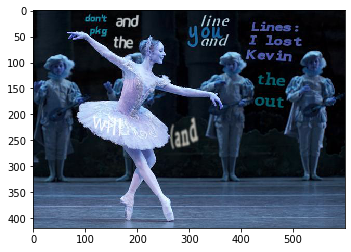

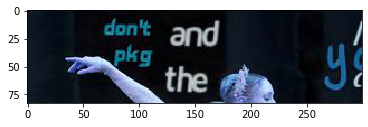

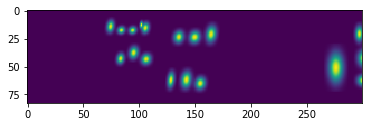

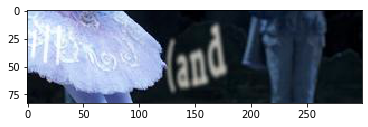

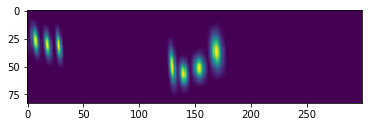

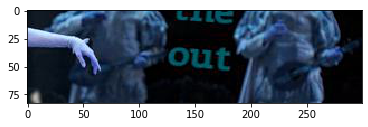

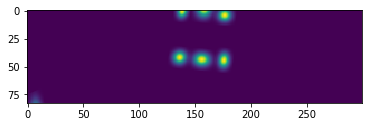

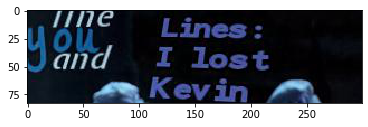

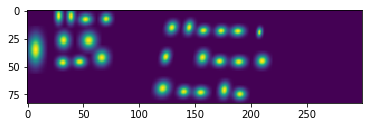

In [22]:
# plt.figure()
# plt.imshow(gt.cpu().permute(2,0,1)[0])
plt.figure()
plt.imshow(img.permute(1,2,0))

plt.figure()
plt.imshow(hard_img[0].transpose(1,2,0))
plt.figure()
plt.imshow(hard_gt[0].cpu()[0])

plt.figure()
plt.imshow(hard_img[1].transpose(1,2,0))
plt.figure()
plt.imshow(hard_gt[1].cpu()[0])

plt.figure()
plt.imshow(hard_img[2].transpose(1,2,0))
plt.figure()
plt.imshow(hard_gt[2].cpu()[0])

plt.figure()
plt.imshow(hard_img[3].transpose(1,2,0))
plt.figure()
plt.imshow(hard_gt[3].cpu()[0])

In [7]:
T = 10
for i, (img, target) in enumerate(dataset, begin):
    if i % T == T-1:
        print(i)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199
209
219
229
239
249
259
269
279
289
299
309
319
329
339
349
359
369
379
389
399
409
419
429
439
449
459
469
479
489
499
509
519
529
539
549
559
569
579
589
599
609
619
629
639
649
659
669
679
689
699
709
719
729
739
749
759
769
779
789
799
809
819
829
839
849
859
869
879
889
899
909
919
929
939
949
959
969
979
989
999
1009
1019
1029
1039
1049
1059
1069
1079
1089
1099
1109
1119
1129
1139
1149
1159
1169
1179
1189
1199
1209
1219
1229
1239
1249
1259
1269
1279
1289
1299
1309
1319
1329
1339
1349
1359
1369
1379
1389
1399
1409
1419
1429
1439
1449
1459
1469
1479
1489
1499
1509
1519
1529
1539
1549
1559
1569
1579
1589
1599
1609
1619
1629
1639
1649
1659
1669
1679
1689
1699
1709
1719
1729
1739
1749
1759
1769
1779
1789
1799
1809
1819
1829
1839
1849
1859
1869
1879
1889
1899
1909
1919
1929
1939
1949
1959
1969
1979
1989
1999
2009
2019
2029
2039
2049
2059
2069
2079
2089
2099
2109
2119
2129
2139
2149
2159
2169
2179
2189
2199
2209
2219
2

KeyboardInterrupt: 

In [26]:
# input: NCHW
# output: NHWC
model = CRAFT(pretrained=True, num_class=1).cuda()

# weight_path = "/home/eee198/Downloads/SynthText/weights/w_10000"
# model.load_state_dict(torch.load(weight_path))
# model.eval()

In [27]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [41]:
T_save = 10000
T = 100
epochs = 1
start = time.time()
for epoch in range(epochs):
    running_loss = 0.0

    for i, (img, target) in enumerate(dataloader):
        #print(f"image shape = {img.shape}")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output, _ = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % T == T-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
            running_loss = 0.0
        if i % T_save == T_save-1:
            print(f"\nsaving at {i}-th batch'\n")
            torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/w_{i}_.pth")
            end = time.time()
            print(f"\nElapsed time: {end-start}")
            

print("Finished training.")

end = time.time()
print(f"\nTotal elapsed time: {end-start}")
#24700

[1,   100] loss: 0.300577


KeyboardInterrupt: 

In [7]:
img, gt = None, None
for im,g in dataloader:
    print(f"g.size() = {g.size()}")
    img, gt = im, g
    break
img1, gt1 = img.clone(), gt.clone()

g.size() = torch.Size([1, 199, 300, 1])


In [8]:
# testing for overfitting
T = 100
N = 10000
for i in range(N):
    running_loss = 0.0
    
    optimizer.zero_grad()
    
    output,_ = model(img)
    loss = criterion(output, gt)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % T == T-1:
        print('[%d] loss: %f' % (i + 1, running_loss/T))
        running_loss = 0.0

[100] loss: 0.000869
[200] loss: 0.000427
[300] loss: 0.000236
[400] loss: 0.000154
[500] loss: 0.000113
[600] loss: 0.000090
[700] loss: 0.000076
[800] loss: 0.000067
[900] loss: 0.000060
[1000] loss: 0.000055
[1100] loss: 0.000051
[1200] loss: 0.000048
[1300] loss: 0.000046
[1400] loss: 0.000044
[1500] loss: 0.000042
[1600] loss: 0.000040
[1700] loss: 0.000039
[1800] loss: 0.000038
[1900] loss: 0.000037
[2000] loss: 0.000036
[2100] loss: 0.000035
[2200] loss: 0.000034
[2300] loss: 0.000034
[2400] loss: 0.000033
[2500] loss: 0.000032
[2600] loss: 0.000032
[2700] loss: 0.000031
[2800] loss: 0.000031
[2900] loss: 0.000030
[3000] loss: 0.000030
[3100] loss: 0.000030
[3200] loss: 0.000029
[3300] loss: 0.000029
[3400] loss: 0.000028
[3500] loss: 0.000028
[3600] loss: 0.000028
[3700] loss: 0.000027
[3800] loss: 0.000027
[3900] loss: 0.000027
[4000] loss: 0.000026
[4100] loss: 0.000026
[4200] loss: 0.000026
[4300] loss: 0.000025
[4400] loss: 0.000025
[4500] loss: 0.000025
[4600] loss: 0.0000

In [76]:
model.load_state_dict(torch.load(f"/home/eee198/Downloads/SynthText/weights/w_23600.pth"))
model.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, 

In [9]:
img1, gt1 = img.clone(), gt.clone()
print("image shape: ", img1.shape)
print("gt shape: ", gt1.shape)

image shape:  torch.Size([1, 3, 399, 600])
gt shape:  torch.Size([1, 199, 300, 1])


In [8]:
img, gt = dataset[1]
# print(f"min(img) = {torch.min(img)}\nmin(gt) = {torch.min(gt)}")
# print(f"max(img) = {torch.max(img)}\nmax(gt) = {torch.max(gt)}")

AssertionError: Colinear BB coordinates

In [6]:
plt.figure()
x = (img.permute(1,2,0))*255
plt.imshow(x.cpu())

NameError: name 'img' is not defined

<Figure size 432x288 with 0 Axes>

gt shape = torch.Size([199, 300, 1])
shape = torch.Size([199, 300])


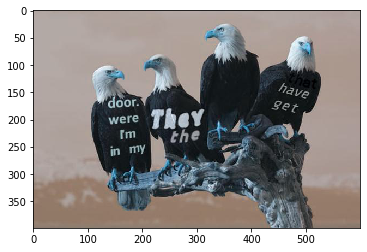

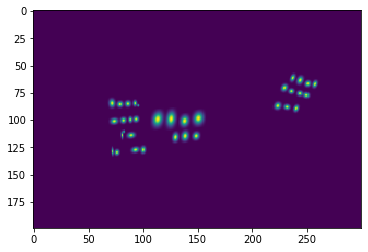

In [10]:
plt.figure()
x = (img1[0].permute(1,2,0))*255
plt.imshow(x.cpu().numpy().astype('int'))

gt_shape = gt1[0].size()
print(f"gt shape = {gt_shape}")
gt = gt1[0].view([gt_shape[2],gt_shape[0],gt_shape[1]])
for map in gt:
    print(f"shape = {map.size()}")
    plt.figure()
    plt.imshow(map.cpu().numpy())

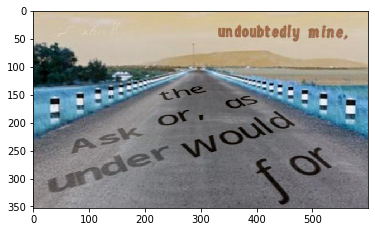

In [49]:
img, gt = None, None
for img, gt in dataloader:
    image = img[0].permute(1,2,0).cpu().numpy()
    image.shape
    plt.imshow(image)
    break

In [11]:
print("input shape: ", end="")
print(img.shape)
output, _ = model(img)
print("output shape: ", end="")
print(output.shape)

input shape: torch.Size([1, 3, 399, 600])
output shape: torch.Size([1, 199, 300, 1])


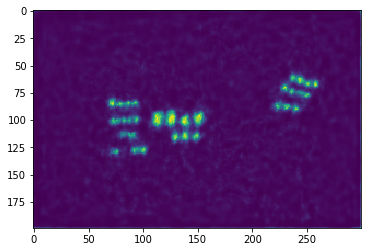

In [12]:
img_out = output.view(199,300).cpu().detach().numpy()
plt.imshow(img_out)

In [31]:
print(np.max(img_out), np.min(img_out))

0.22952314 2.6491716e-06
